## COMP Question 10: What does the community want to know?

Authors: dtradke, CCV

Date: April 26, 2021

This notebook addresses question 10 using Flipside Crypto data at the following link (https://www.notion.so/Analytics-Bounties-for-Compound-62013e59c5d04b4281d0868efdcfaab0?p=189e27d6567e42c78af259956f6a0c64). For this question, we must come up with questions that we believe the community wants to know about Compound (COMP), and provide insightful solutions to those questions. We design the following questions to lead our analysis:

-Is there a relationship between the price of COMP and the broader blockchain sector?
-What resolution are these relationships best found?
-Can changes in the price of COMP be anticipated by studying the broader blockchain sector?

To answer this question, we sourced COMP price information from the Flipside Crypto dataset since the inception of the currency. We also collected third party data for the Crypto Currencies Index (CCI30), a rules-based index designed to objectively measure the overall growth, daily, and long-term movement of the blockchain sector. CCI30 does this by tracking the 30 largest cryptocurrencies by market capitalization, excluding stablecoins. We found CCI30 data at the following link (https://cci30.com/#:~:text=CCi30&text=The%20CCi30%20is%20a%20rules,by%20market%20capitalization%2C%20excluding%20stablecoins). 

Our solution is based off of methods used in the artificial intelligence field of Natural Language Processing (NLP). Specifically, we adopt the method of Dynamic Time Warping (DTW) to compute a distance cost between specific segments of COMP and CCI30. More information on the underlying method of DTW can be found at (https://en.wikipedia.org/wiki/Dynamic_time_warping).
First, we import the necessary libraries for data processing, and the backend code for data analysis which is included in the file "util.py".

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Next, we import the file "util.py" which contains all of the backend code to load and format our data appropriately.

In [2]:
import util

Now we import the historical prices of COMP which we obtained from the Flipside Crypto dataset for every hour since the inception of COMP. Since this data is recorded hourly, we prune the previous 19 hours to round the dataset to midnight of the desired day.

In [3]:
url = 'https://api.flipsidecrypto.com/api/v2/queries/45532a0e-759e-4a63-9995-c086b66ff547/data/latest'
comp_price = util.loadData(url)
comp_price = np.array(comp_price["TOKEN_PRICE"])[:-19]
avg_comp_price = util.meanCOMP(comp_price)

Next, we load the CCI30 data from a CSV file that we downloaded previously. We then take the previous N days corresponding to the amount of days since COMP's inception.

In [4]:
path = "data/cci30_OHLCV.csv"
market_avg = util.loadMarketAvg(path)
market_avg = market_avg[(-1*avg_comp_price.size):]

In order to make direct comparisons of the shapes of data, we must normalize the prices to project them into the same scale. The following code normalizes the price datasets between 0 and 1 each.

In [5]:
# normalize the data for direct comparison
avg_comp_price = (avg_comp_price - np.amin(avg_comp_price)) / (np.amax(avg_comp_price) - np.amin(avg_comp_price))
market_avg = (market_avg - np.amin(market_avg)) / (np.amax(market_avg) - np.amin(market_avg))

### Experiment 1: Direct DTW Window Comparison

In this experiment, we compare direct window sizes of N samples of COMP and CCI30. The window size corresponds with the number of days, so a window size of 7 would mean we compare 7 days of COMP price data with the corresponding 7 days of CCI30 data. DTW arranges the two time series along the x and y axis of a 2-dimensional cost matrix. The m,n entry of the cost matrix corresponds with the difference in value and position from value m in the COMP data to value n in the CCI30 data. The total cost of comparing these two time series is calculated as the "path of least cost" from one corner of the matrix to the mirroring corner, and the costs are summed. Therefore, higher cost values between the COMP window of data and the CCI30 window of data correspond with more of a difference, and vice-versa. We normalize the cost for window size so that longer windows do not simply incur greater cost.


Our first window size is 1 day, the equivalent of a direct difference comparison. The graphs in our study have time since the COMP inception along the x-axis in days, the normalized price along the y-axis, and the DTW cost shaded in the background so that darker blue days have more cost, and whiter days have less cost. The results of the 1-day window show that COMP was much more in-line with CCI30 in for the first few months after inception. Dispite the increased error at 4-5 months after inception, comparing these two time series together only incurs a mean cost of 0.0918. We also plot a histogram showing the distribution of costs along the entire time series with a standard deviation of 0.1162.

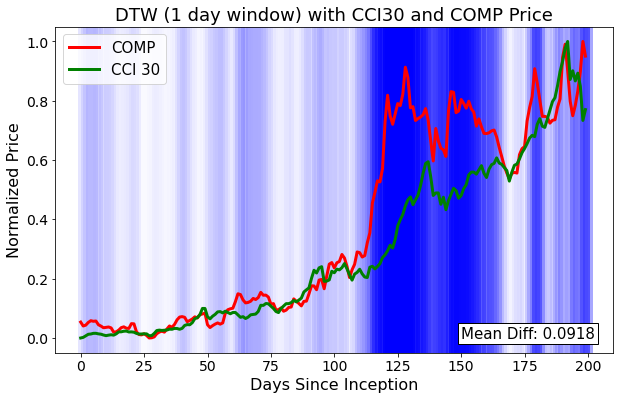

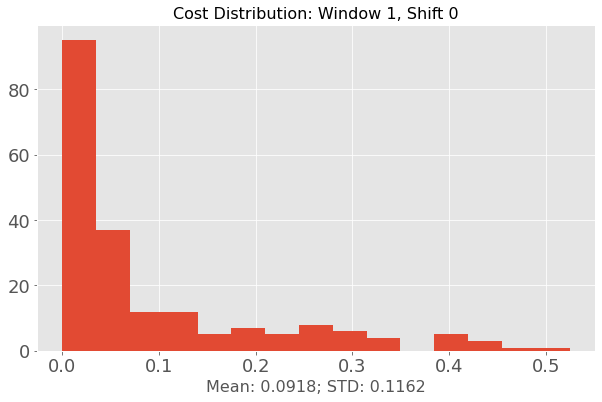

In [6]:
# window 1
window = 1
diffs = util.doDTW(avg_comp_price, market_avg, window)
util.plotCompare(avg_comp_price, market_avg, diffs, window)

We now test a window size of 4 days. We do not notice any significant difference in the calculated cost, exept that the regions with the least cost seem to converge closer to 0 and are more white. The mean cost is slightly less at 0.0898 and the standard deviation also decreases to 0.113, meaning the error converges to similar areas.

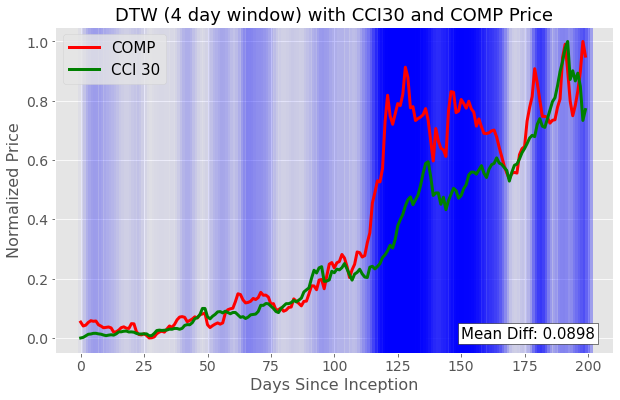

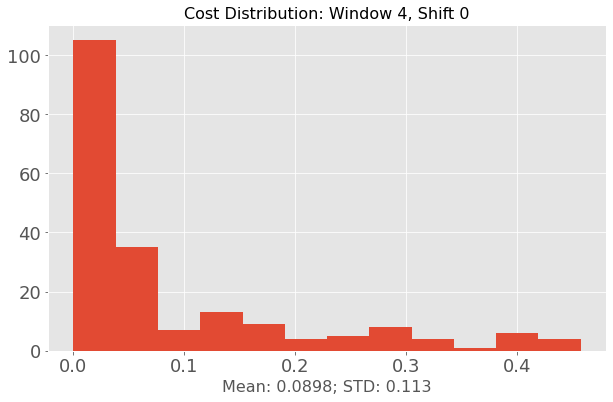

In [14]:
# window 4 days
window = 4
diffs = util.doDTW(avg_comp_price, market_avg, window)
util.plotCompare(avg_comp_price, market_avg, diffs, window)

Next, we test a window size of 8 days. We once again record slightly lower mean cost of 0.0867, however the areas with the highest cost seem to hoard the darkes shades of blue even more, suggesting that the error standard deviation is shrinking with more days considered, which is confirmed with the smaller standard deviation 0.1108.

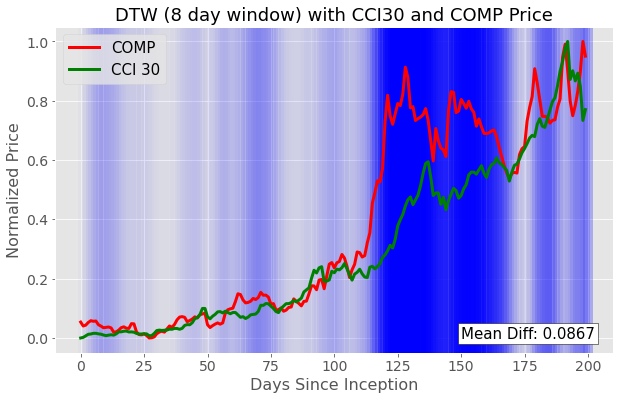

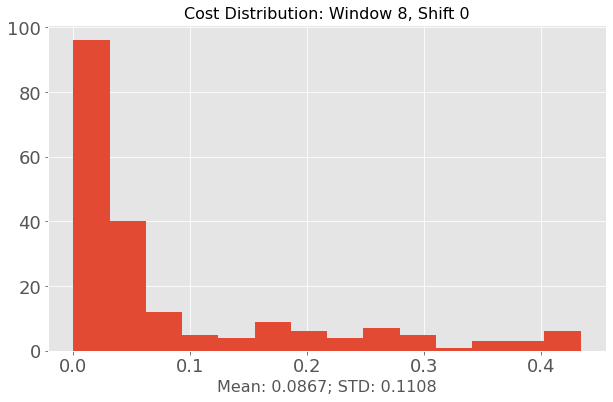

In [16]:
# window 8 days
window = 8
diffs = util.doDTW(avg_comp_price, market_avg, window)
util.plotCompare(avg_comp_price, market_avg, diffs, window)

Finally, we consider a window size of 16 days. We see the mean cost difference slightly decrease at 14 days resulting in a mean cost of 0.0807. The distirbution of the background colors converges around the 1-month stretch of high cost even more than previously, and the actual standard deviation decreases even more to 0.1001.

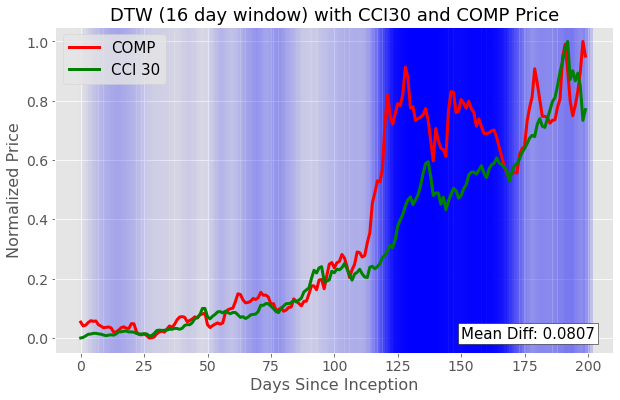

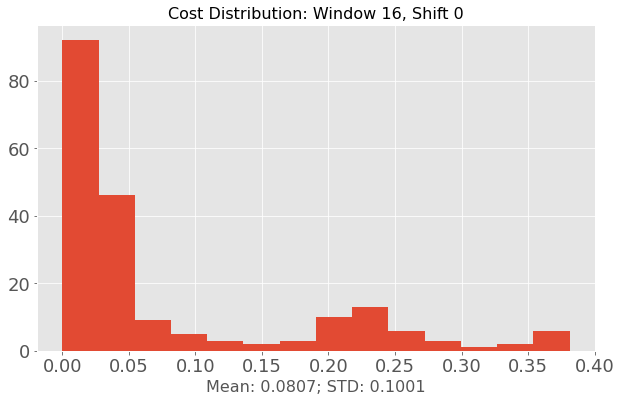

In [17]:
# window 16 days
window = 16
diffs = util.doDTW(avg_comp_price, market_avg, window)
util.plotCompare(avg_comp_price, market_avg, diffs, window)

### Experiment 2: Shifting the DTW Window of Comparison

This experiment is aimed at understanding if the movement of CCI30 and help us anticipate the future movement of COMP. To do this, we offset the window using a "shift" variable, which offsets the COMP and CCI30 windows by "shift". Therefore, if there is less cost than the direct comparison, we would see a positive correlation for CCI30 predicting the movement of COMP.

Our first experiment is back with the window size of 1, shifted by 1 day. We see a decrease in the overall cost from 0.0918 to 0.0907, suggesting that the time series is a better fit when CCI30 is used as a predictor for the movement of COMP. The standard deviation of error also decreases from 0.1162 to 0.1115.

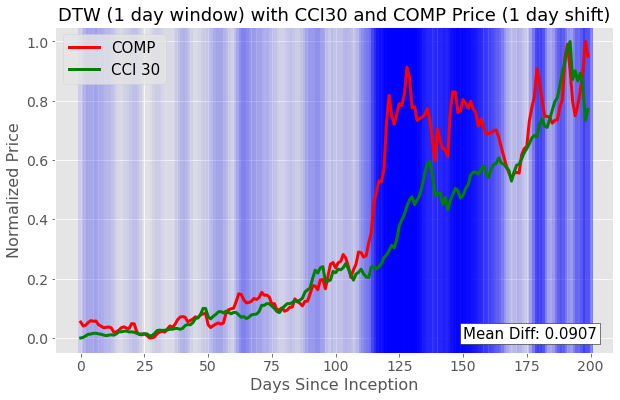

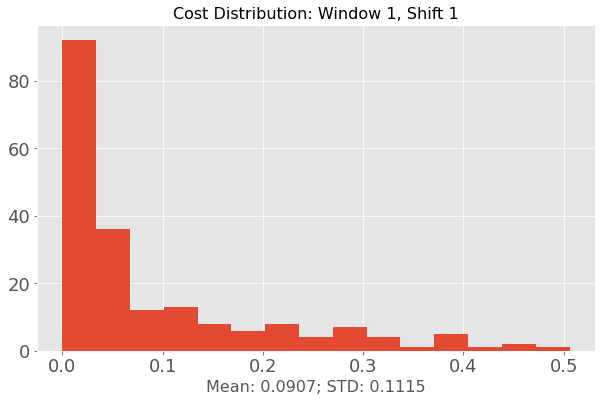

In [19]:
# window 1, shift 1
window = 1
shift = 1
diffs = util.doDTW(avg_comp_price, market_avg, window, shift)
util.plotCompare(avg_comp_price, market_avg, diffs, window, shift)

Next, we consider a window size of 4 days, offset by 2 days. We observe a slightly less mean cost of 0.0894 compared to before the shift of 2 days, and the standard deviation also decreases to 0.1039.

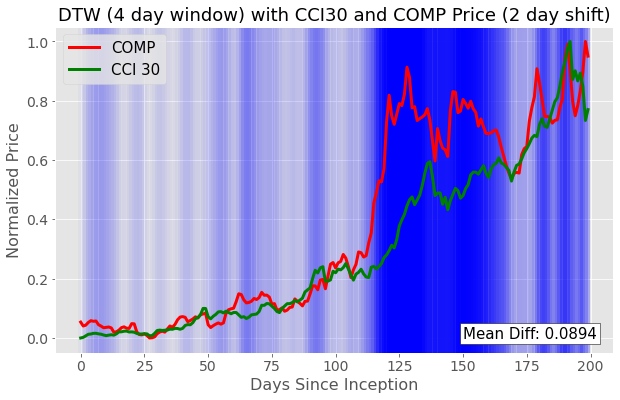

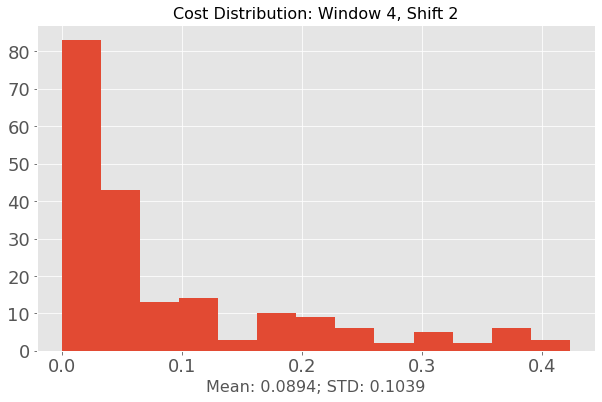

In [20]:
# window 4, shift 2
window = 4
shift = 2
diffs = util.doDTW(avg_comp_price, market_avg, window, shift)
util.plotCompare(avg_comp_price, market_avg, diffs, window, shift)

Now we consider a window size of 8 days, shifted by 4 days each. In this trial, we observe another decrease in mean cost to 0.0858 compared to 0.0867 previously without the shift, and the standard deviation decreases even more to 0.0937.

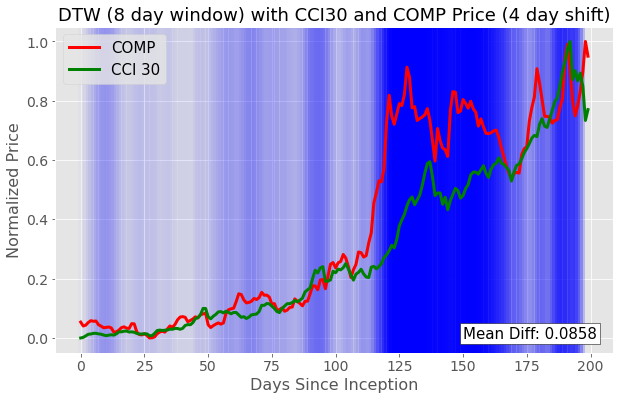

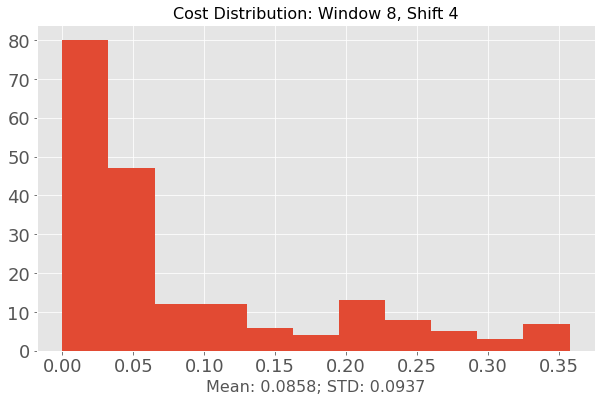

In [21]:
# window 8, shift 4
window = 8
shift = 4
diffs = util.doDTW(avg_comp_price, market_avg, window, shift)
util.plotCompare(avg_comp_price, market_avg, diffs, window, shift)

Finally, we now consider our largest window size of 16 days, shifted by 8 days each. We observe the largest decrease in mean cost down to 0.073, suggesting that the greater consideration of 16 days, paired with the largest shift of 8 days, is helpful when anticipating the cost of COMP compared to the CCI30 data. The standard deviation is also the lowest in this experiment with 0.077.

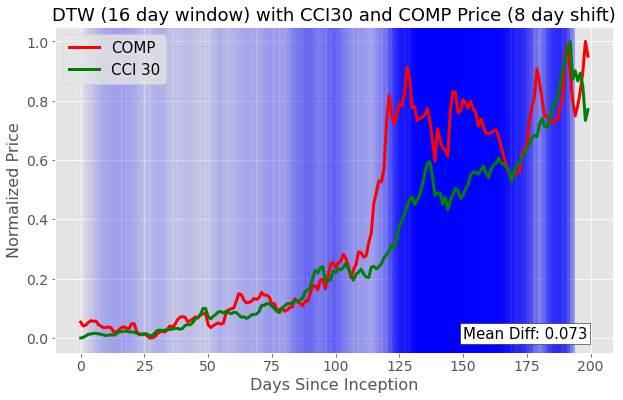

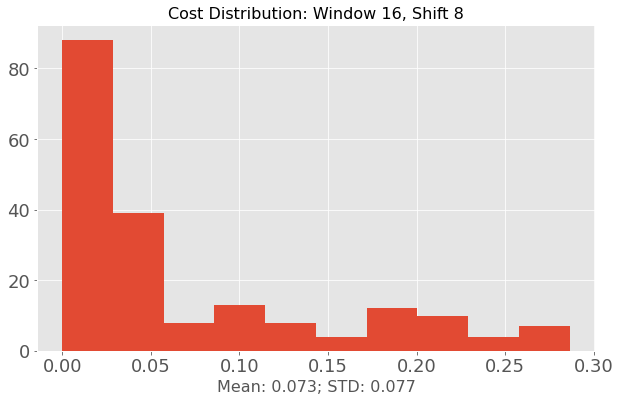

In [22]:
# window 16, shift 8
window = 16
shift = 8
diffs = util.doDTW(avg_comp_price, market_avg, window, shift)
util.plotCompare(avg_comp_price, market_avg, diffs, window, shift)

## Conclusion

We have compared COMP price data since inception with the CCI30 rules-based index showing trends in the general blockchain sector. We used Dynamic Time Warping to compare segments of 1, 4, 8, and 16 days between the two entities to determine what the most appropriate window length is. Furthermore, we found that offsetting the windows by half of their length led to lower DTW cost, meaning that the general trends of the CCI30 data could help predict the movement of COMP better than a direct comparison. We also tracked the standard deviations of the DTW cost calculated for different window sizes, and found that as we increased window size and offset the windows by half, the standard deviation decreased and high cost converged to a smaller part of the comparison. This could be helpful when anticipating how the COMP price will change over time.

Furthermore, a general trend that was consistent across all of our experiments was the lowest cost being in the first 100 days of COMP. This may suggest that, COMP has broken away from general trends as of late, however we also note that the cost of recent COMP behaviour is decreasing. This suggests that perhaps future data will grow to become more in-line with the trends seen in the CCI30 index.